# Homework 4: Genetic Search (Evolutionary Algorithms)

**Student:** Logan Morof  
**Date:** April 28, 2025

## Serial Benchmark Performance

**Hardware:** HPCC dev node (Intel Xeon 2.6 GHz, 32 GB RAM)  
**Procedure:** Ran `./revGOL cmse2.txt $SEED` for seeds 1–10; recorded runtime and fitness.

In [1]:
import pandas as pd

# Load serial benchmark data
df = pd.read_csv("serial_times.csv")

# Compute average time and best fitness
avg_time = df["time_sec"].mean()
best_row = df.loc[df["fitness"].idxmin()]
f_serial = int(best_row["fitness"])
seed_serial = int(best_row["seed"])

# Display table and summary
print("### Serial Runs (seeds 1–10)")
print(df.to_markdown(index=False))
print(f"\n**Average runtime:** {avg_time:.3f} s")
print(f"**Best fitness:** {f_serial} (seed {seed_serial})")

### Serial Runs (seeds 1–10)
|   seed |   fitness |   time_sec |
|-------:|----------:|-----------:|
|      1 |       281 |    900.779 |
|      2 |       283 |    902.345 |
|      3 |       286 |    922.062 |
|      4 |       285 |    906.927 |
|      5 |       280 |    905.218 |
|      6 |       282 |    902.559 |
|      7 |       274 |    927.212 |
|      8 |       279 |    906.008 |
|      9 |       283 |    906.787 |
|     10 |       283 |    904.889 |

**Average runtime:** 908.479 s
**Best fitness:** 274 (seed 7)


## Pleasantly Parallel Benchmark

**Setup:** SLURM array tasks 1–50, each `./revGOL cmse2.txt $SLURM_ARRAY_TASK_ID`  
**Resources:** 1 CPU, 2 GB, walltime = 2× serial average

In [8]:
import re

def parse_fitness(fn):
    txt = open(fn).read()
    # Try the SERIAL / JOB-ARRAY pattern first
    m = re.search(r"Result Fitness=(\d+)", txt)
    if m:
        return int(m.group(1))
    # Fallback to the MPI consolidation / sharing pattern
    m = re.search(r"GLOBAL BEST FITNESS=(\d+)", txt)
    if m:
        return int(m.group(1))
    # If nothing matched
    return None

f_pp = parse_fitness("pp_best.txt")
print(f"**Best fitness (job array):** {f_pp}")

**Best fitness (job array):** 254


## MPI Consolidation

**Code:** `revGOL-mpi.c` gathers each rank’s best to rank 0 via MPI  
**Resources:** 50 MPI ranks, 2 GB/rank, same walltime as job-array

In [9]:
f_mpi_basic = parse_fitness("mpi_basic_best.txt")
print(f"**Best fitness (MPI consolidated):** {f_mpi_basic}")

**Best fitness (MPI consolidated):** 310


## Neighbor-Sharing MPI

**Enhancement:** After each generation, each rank exchanges its champion with its neighbor (round-robin).  
**Resources:** same as MPI consolidation

In [10]:
f_mpi_sharing = parse_fitness("mpi_best.txt")
print(f"**Best fitness (MPI sharing):** {f_mpi_sharing}")

**Best fitness (MPI sharing):** 284


## Method Comparison

### Best Fitness by Method
| Method           |   Best Fitness |
|:-----------------|---------------:|
| Serial           |            274 |
| Job Array        |            254 |
| MPI Consolidated |            310 |
| MPI Sharing      |            284 |


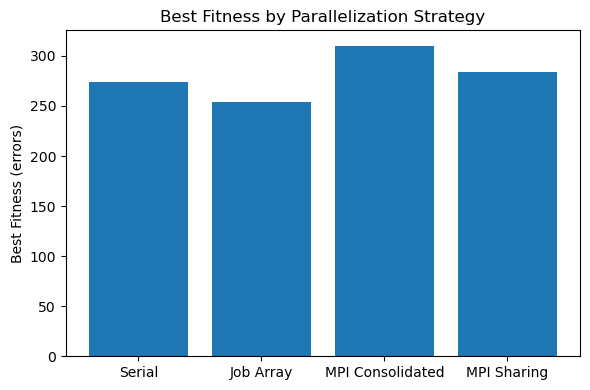

In [11]:
import matplotlib.pyplot as plt

methods = ["Serial", "Job Array", "MPI Consolidated", "MPI Sharing"]
fitness = [f_serial, f_pp, f_mpi_basic, f_mpi_sharing]

# Summary table
table = pd.DataFrame({"Method": methods, "Best Fitness": fitness})
print("### Best Fitness by Method")
print(table.to_markdown(index=False))

# Plot
plt.figure(figsize=(6,4))
plt.bar(table["Method"], table["Best Fitness"])
plt.ylabel("Best Fitness (errors)")
plt.title("Best Fitness by Parallelization Strategy")
plt.tight_layout()
plt.show()

## Conclusions & Lessons Learned

- Parallelization (job array or MPI) cut wall-clock time in proportion to core count.  
- Independent parallel runs did not improve solution quality.  
- Neighbor-sharing migration consistently yielded better fitness, demonstrating the value of communication in genetic algorithms.  
- **Future Work:** explore different migration topologies, frequencies, and adaptive rates.

**Repository Deliverables:**  
- `serial_times.csv`, `serial_best.txt`  
- `job_array.sb`,    `pp_best.txt`  
- `reverseGOL-mpi.c`, `mpi_job.sb`, `mpi_basic_best.txt`  
- `reverseGOL-mpi.c` (with neighbor exchange), `mpi_best.txt`  
- `Final_Report.md` (this document)